# Лабораторная работа №1 — Сумма элементов вектора

В данной лабораторной работе был реализован алгоритм сложения элементов вектора на GPU с применением CUDA.

**Входные данные:** Вектор размером от 1000 до 1000000 значений.

**Выходные данные:** сумма элементов вектора + время вычисления.

In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


In [ ]:
!nvidia-smi

Wed Jan  5 22:50:27 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Реализация

Следующий код реализует суммирование массива `idata` произвольной длины N, результат суммирования записывается в нулевой элемент вектора `odata`. 

In [ ]:
import numpy as np
from numba import cuda, float32
from time import time
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
TPB = 32

In [ ]:
@cuda.jit
def vec_reduce(idata, odata):
    # каждый поток загружает один элемент из глобальной в общую память
    sdata = cuda.shared.array(TPB, dtype=float32)
    
    tid = cuda.threadIdx.x
    i = cuda.blockIdx.x * cuda.blockDim.x + tid
    
    sdata[tid] = idata[i]
    cuda.syncthreads()

    # в цикле производится операция редукции  
    s = 1
    while s < cuda.blockDim.x:     
        index = 2 * s * tid
        if (index < cuda.blockDim.x):
            sdata[index] += sdata[index + s]
        cuda.syncthreads()      
        s *= 2

    # результат для текущего блока записывается в глобальную память
    if (tid == 0):
        cuda.atomic.add(odata, 0, sdata[0])

## Проверка корректности результата

In [ ]:
y = [2 ** i for i in range(10, 21)]
presision = 1e-2
x_cpu = []
x_gpu = []
acc = []

for n in y:
    MATRIX_SIZE = n

    input_vec = np.random.randn(MATRIX_SIZE).astype(np.float32)
    output_vec = np.zeros(MATRIX_SIZE).astype(np.float32)

    ctic = time()
    res_cpu = input_vec.sum()
    ctoc = float(time() - ctic)
    x_cpu.append(ctoc)

    input_vec_gpu = cuda.to_device(input_vec)
    output_vec_gpu = cuda.to_device(output_vec)


    gtic = time()
    vec_reduce[n // TPB, TPB](input_vec_gpu, output_vec_gpu)
    gtoc = float(time() - gtic)
    x_gpu.append(gtoc)

    acc.append(ctoc / gtoc)

    print("N:", n, "Корректность результата:", np.abs(output_vec_gpu.copy_to_host()[0] - res_cpu) < presision)

N: 1024 Корректность результата: True
N: 2048 Корректность результата: True
N: 4096 Корректность результата: True
N: 8192 Корректность результата: True
N: 16384 Корректность результата: True
N: 32768 Корректность результата: True
N: 65536 Корректность результата: True
N: 131072 Корректность результата: True
N: 262144 Корректность результата: True
N: 524288 Корректность результата: True
N: 1048576 Корректность результата: True


## Сравнение работы алгоритмов на GPU и CPU

In [ ]:
pd.DataFrame.from_dict({'N': y,'CPU time': x_cpu, 'GPU time': x_gpu})

,N,CPU time,GPU time
0,1024,0.000075,0.686909
1,2048,0.000043,0.000411
2,4096,0.000022,0.000289
3,8192,0.000025,0.000350
4,16384,0.000025,0.000275
5,32768,0.000031,0.000259
6,65536,0.000060,0.000263
7,131072,0.000069,0.000270
8,262144,0.000177,0.000286
9,524288,0.000236,0.000309


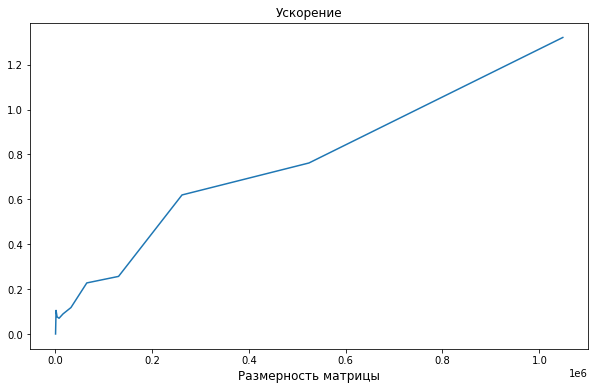

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(y, acc)
plt.title(label='Ускорение')
plt.xlabel('Размерность матрицы', fontsize=12)

plt.show()

Ускорение работы программы на GPU относительно CPU очень долго не превышает 1 вследствие того, что много времени тратится на распараллеливание алгоритма. Поэтому, если количество элементов вектора не близко к 1 000 000, сумму будет выгоднее считать на CPU.